# **K - Nearest Neighbors**  
  
  
The K - Nearest Neighbors (kNN) is one of the simplest machine learning algorithms that can be used for both regression and classification. kNN is a lazy machine learning algorithm and doesn't technically train a model to make predictions. Instead an observation is predicted to be the class of that of the largest proportion of the k nearest observations. kNN method is a direct attempt at approximating the conditional expectation using actual data.  
  
For **classification**, the predicted label is the class with the plurality, i.e., which class is most represented among the neighbors. This is equivalent to taking a majority vote among the $\textbf{k}$ nearest neighbors. For each class $j = 1, ..., K$, we then compute the probability:
   
$
\begin{equation}
P(G = j | X = x_0) = \frac{1}{k} \sum_{i \in N_k(x)} I(y_i = j)
\end{equation}
$  
  
and assign the observation to the class with the highest empirical probability. Here, $I(y_{i} = j)$ is the indicator function returning 1 if $y_{i} = j$ and 0 otherwise.



# **Problem Statement**

The objective is to predict market movement based on classification algorithm. In this lab, we'll use KNN to predict market direction and devise a trading strategies based on it.

In [ ]:
import pandas as pd
import numpy as np
from pylab import mpl, plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

<ipython-input-1-724e2ef069f6>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **Load Data**

In this project, we will using the Nifty index price data to predict the market movement devise a strategy.

In [ ]:
df = pd.read_csv('/content/spy.csv')

df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/spy.csv'

# **EDA of Dataset**

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5.114000e+03
mean,159.857972,160.798386,158.829985,159.860942,136.333938,1.127593e+08
std,60.679463,60.830274,60.515930,60.694065,67.923663,9.870486e+07
min,67.949997,70.000000,67.099998,68.110001,54.184429,1.436600e+06
25%,115.752501,116.662502,114.902502,115.897499,87.412493,4.821255e+07
50%,137.085007,137.955002,136.110001,136.945000,106.488850,8.357545e+07
75%,201.767498,202.787498,200.722504,201.872505,182.951584,1.515544e+08
max,337.790009,339.079987,337.480011,338.339996,336.362091,8.710263e+08


# **Data Cleaning & Imputation**

Data is already cleaned. No further processing or imputation required.

In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


# **Feature Engineering**

We will create a new features set from the original dataset to predict our target variable.

In [ ]:
# Predictors
df['O-C'] = df['Open'] - df['Close']
df['H-L'] = df['High'] - df['Low']

X = df[['O-C', 'H-L']].values

# **Labels Definition**

The target variable is whether the Nifty Index price will close up or down on the next trading day. If tomorrow's closing price is greater than 99.5% of today's closing price, then we will buy the Nifty; otherwise, we will sell the index.

We assign a value of \( +1 \) for the buy signal and \( -1 \) for the sell signal to the target variable. The target variable can be defined as:  
  
$
y_{t} =
\begin{cases}
    +1, & \text{if } p_{t+1} > 0.995 \times p_{t}, \\
    -1, & \text{otherwise}.
\end{cases}
$

where, $p_{t}$ is the closing price of Nifty index and $p_{t+1}$ is the 1-day forward closing price of index.


In [ ]:
y = np.where(df['Adj Close'].shift(-1) > 0.995 * df['Adj Close'], 1, -1)
y

array([-1, -1,  1, ...,  1,  1, -1])

In [ ]:
pd.Series(y).value_counts()

,count
1,3885
-1,1229


# **Split Data**

In [ ]:
# Splitting the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state = 42)
print(f'Train & Test size is: {len(X_train)}, {len(X_test)}')

Train & Test size is: 4091, 1023


# **Fit Model**

Since the kNN model calculates distances, the dataset needs to be scaled for the model to work properly. All the features should have a similar scale. The scaling can be accomplished by using the MinMaxScaler transformer.

In [ ]:
# Scale and fit the model
model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', KNeighborsClassifier())
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

# **Predict Model**

In [ ]:
# Predicting test dataset
y_pred = model.predict(X_test)

# Predict probabilities
y_proba = model.predict_proba(X_test)

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_pred, y_test)

print(f'Train accuracy score: {acc_train}', f'Test accuracy score: {acc_test}')

Train accuracy score: 0.7802493277927157 Test accuracy score: 0.7497556207233627


# **Predict Quality**

**Confusion Matrix**

Confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known.

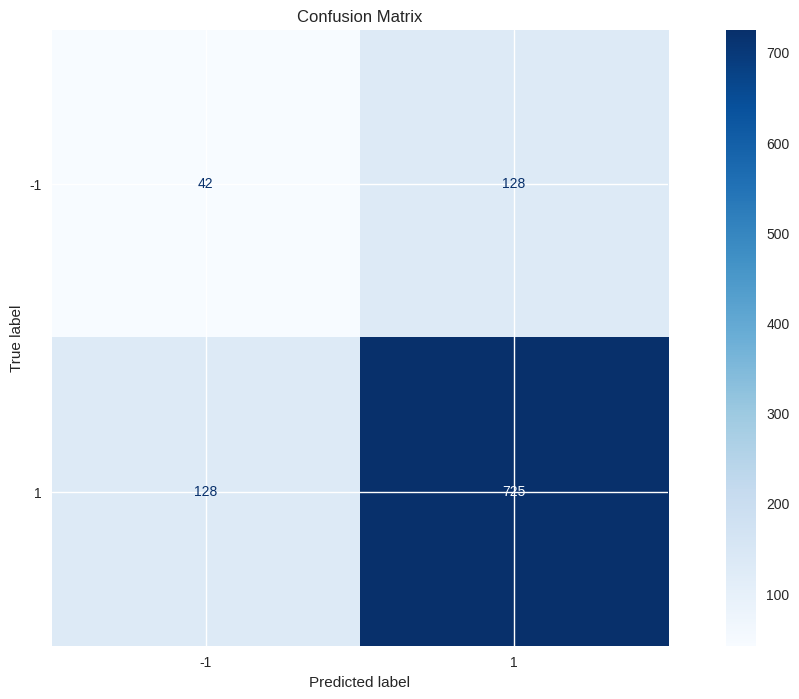

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels = model.classes_,
    cmap = plt.cm.Blues
)
disp.ax_.set_title('Confusion Matrix')
plt.show()

**Classification Report**

A classification report is used to measure the quality of predictions from a classification algorithm.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.25      0.25      0.25       170
           1       0.85      0.85      0.85       853

    accuracy                           0.75      1023
   macro avg       0.55      0.55      0.55      1023
weighted avg       0.75      0.75      0.75      1023



**ROC Curve**

The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.

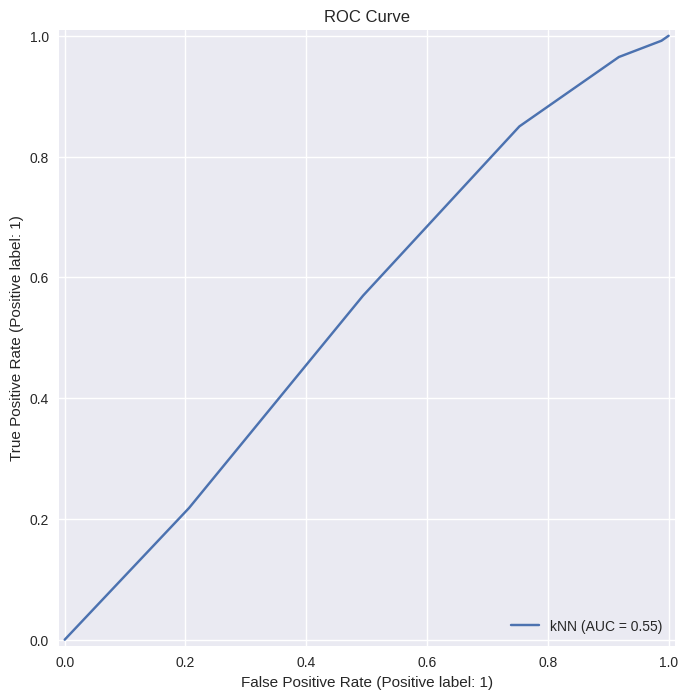

In [ ]:
# Display ROC curve
disp_roc = RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    name = 'kNN'
)
disp_roc.ax_.set_title('ROC Curve')
plt.show()

# **Hyperparameter Tuning**

In this step, we will search for the optimal hyperparameter which provide the best cross - validation score. This process is called hyperparameter tuning.  
   
We will tune the hyperparameters to select the K - Best Neighbor by TimesSeriesSplit from sklearn. This is a forward chaining cross - validation method and is a variation from the K - fold. In the $k^{th}$ split, it returns first k folds as train set and the $(k+1)^{th}$ fold as test set. Unlike standard cross validation methods, successive training sets are supersets of those that come before them.

In [ ]:
# Cross - validation
tscv = TimeSeriesSplit(n_splits = 5, gap = 1)

**Grid Search**

We will apply grid search algorithm for performing hyperparameter optimization. It is an exhaustive search through a manually specified subset of the hyperparameter space of learning algorith.

In [ ]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [ ]:
# Perform grid search & fit
param_grid = {'classifier__n_neighbors': np.arange(1, 51, 1)}

# Perform grid search & fit
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [ ]:
# Best params & scores
print(f"Optimal Neighbors: {grid_search.best_params_['classifier__n_neighbors']}, Best Scores: {grid_search.best_score_}")

Optimal Neighbors: 18, Best Scores: 0.5361196961181978


# **Tuned Model**

Let's now train and predict the model with the best search parameter.

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors = grid_search.best_params_['classifier__n_neighbors'])
# Fit the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

In [ ]:
# Prediction
y_pred_1 = knn_clf.predict(X_test)

# Accuracy score
acc_train1 = accuracy_score(y_train, knn_clf.predict(X_train))
acc_test1 = accuracy_score(y_test, y_pred_1)

# Print accuracy
print(f'Train accuracy score: {acc_train1}', f'Test accuracy score: {acc_test1}')

Train accuracy score: 0.7472500611097531 Test accuracy score: 0.7859237536656891


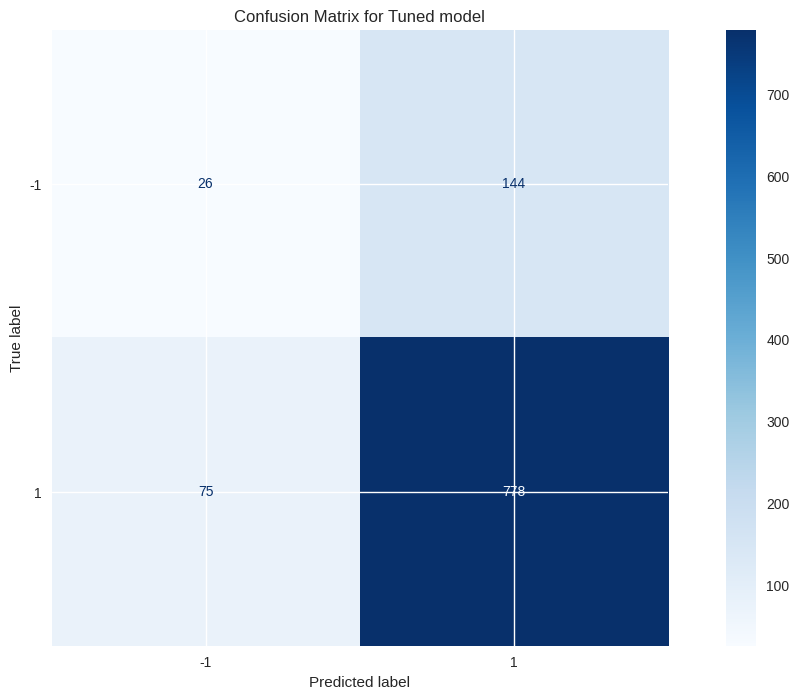

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    knn_clf,
    X_test,
    y_test,
    display_labels = model.classes_,
    cmap = plt.cm.Blues
)
disp.ax_.set_title('Confusion Matrix for Tuned model')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

          -1       0.26      0.15      0.19       170
           1       0.84      0.91      0.88       853

    accuracy                           0.79      1023
   macro avg       0.55      0.53      0.53      1023
weighted avg       0.75      0.79      0.76      1023



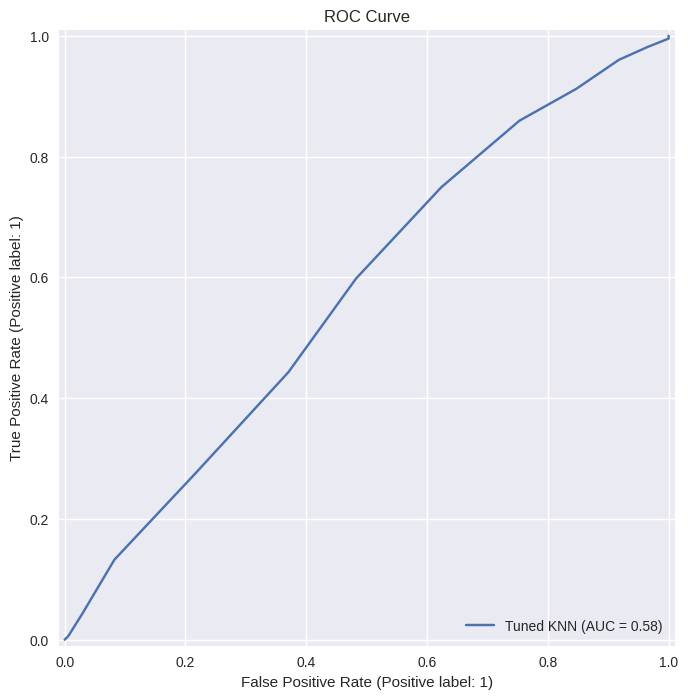

In [ ]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
            knn_clf,
            X_test,
            y_test,
            name='Tuned KNN')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

**Observation**


1.   Test accuracy improved more than 5% as compared to the earlier model.
2.   Recall for Class +1 improved by more than 10% as compared to the earlier model while recall for Class -1 decreased by 40%.
3.   Model improved predictor for upside when compare to the downside.
4.   Class imbalance skews the prediction and needs to be addressed.



# **Trading Strategy**

Let's now define a trading strategy. We will use the predicted signal to buy or sell. We then compare the result of this strategy with the buy and hold and visualize the performance of the kNN algorithm

In [ ]:
# Create a copy
df1 = df.copy()
# Signals
df1['Signals'] = knn_clf.predict(X)

We have to compute the returns for our strategy and the buy-and-hold strategy.

In [ ]:
# Returns
df1['Returns'] = np.log(df['Adj Close']).diff().fillna(0)

# Strategy
df1['Strategy'] = df1['Returns'] * df1['Signals'].shift(1).fillna(0)

# Localize for pyfolio
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)
df1.index = df1.index.tz_localize('utc')

In [ ]:
df1.tail(10)

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signals,Returns,Strategy
Date,,,,,,,,,,,
2020-04-16 00:00:00+00:00,279.149994,280.029999,275.760010,279.100006,279.100006,131798300,0.049988,4.269989,1,0.004813,0.004813
2020-04-17 00:00:00+00:00,285.380005,287.299988,282.399994,286.640015,286.640015,146684800,-1.260010,4.899994,1,0.026657,0.026657
2020-04-20 00:00:00+00:00,282.609985,286.790009,281.350006,281.589996,281.589996,100109300,1.019989,5.440002,1,-0.017775,-0.017775
2020-04-21 00:00:00+00:00,276.730011,278.040009,272.019989,273.040009,273.040009,126385700,3.690002,6.020020,1,-0.030834,-0.030834
2020-04-22 00:00:00+00:00,278.350006,281.000000,276.910004,279.100006,279.100006,93524600,-0.750000,4.089996,-1,0.021952,0.021952
2020-04-23 00:00:00+00:00,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,1.410004,5.190002,1,-0.000072,0.000072
2020-04-24 00:00:00+00:00,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,-2.239990,5.200012,1,0.013842,0.013842
2020-04-27 00:00:00+00:00,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,-1.929993,3.649994,-1,0.014315,0.014315
2020-04-28 00:00:00+00:00,291.019989,291.399994,285.399994,285.730011,285.730011,105270000,5.289978,6.000000,1,-0.004609,0.004609


Plot the strategy returns and the actual returns to compare the two strategies.

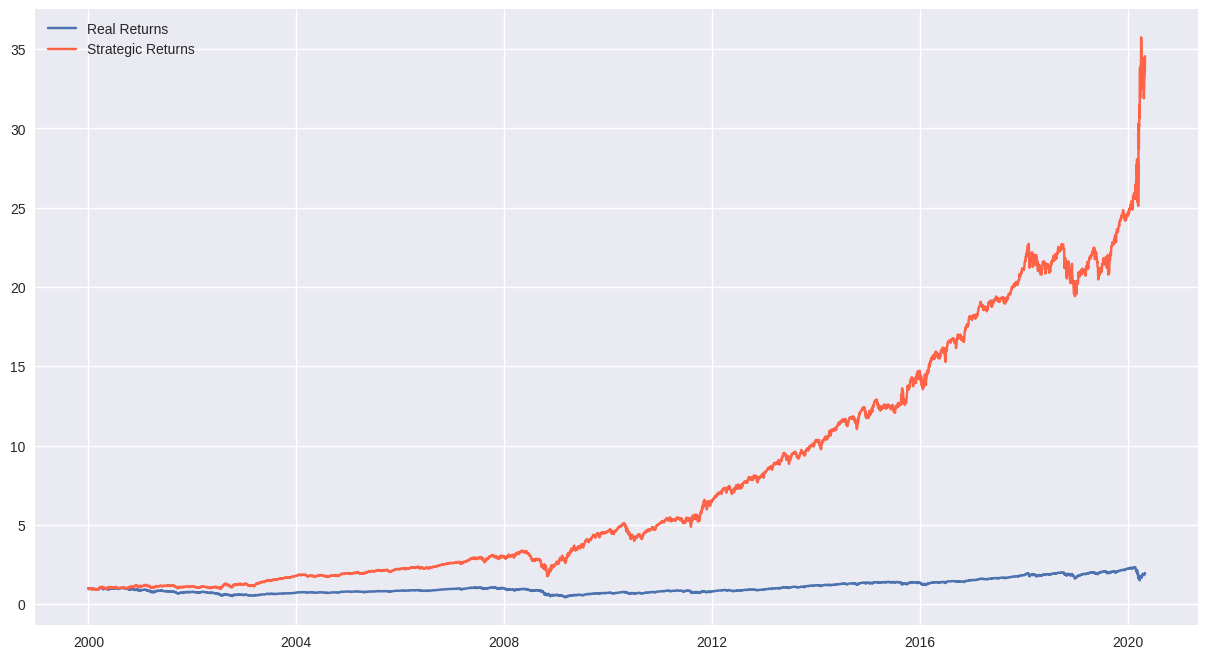

In [ ]:
plt.plot((df1.Returns + 1).cumprod(), label = 'Real Returns')
plt.plot((df1.Strategy + 1).cumprod(), label  = 'Strategic Returns', color = 'tomato')
plt.legend()
plt.show()

# **Conclusion**  
It is clear that our strategy performs more effectively than the traditional buy-and-hold strategy, as its returns are significantly higher than those of the traditional approach.
  
# **Ways to improve**  
  
In this project, we only used the kNN algorithm to predict the Nifty index. However, we could apply the algorithm to a diversified portfolio to potentially earn higher returns.
  
  
Additionally, we can improve the accuracy of our predictions by applying other classification algorithms, such as SVM, Random Forest, or Logistic Regression. These algorithms may perform better than the kNN classifier.